In [15]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import scipy.stats as stats

In [16]:
df = pd.read_csv("./kieranFeatures_1-30_14-Nov-2024_rawSA.csv").replace([np.inf, -np.inf], np.nan).interpolate() # Perform linear interpolation on all non-valid numbers

df["Lv_1_Lo"] = (df["SA1"] < 5).astype(int)
df["Lv_2_Lo"] = (df["SA2"] < 5).astype(int)
df["Lv_3_Lo"] = (df["SA3"] < 5).astype(int)
df["Tot_Lo"] = (df["SAtotal"] < 15).astype(int)

ids = df.iloc[:, 0]
outcomes_df = df.iloc[:, df.shape[1] - 8:]

# Free Memory
del df

In [17]:
# Load data
# with open("./Pickle Files/10_Fold_Test_Split.pkl", "rb") as f:
#     reg_f1_scores, reg_accuracy_scores, reg_CV_models, reg_modified_LASSO_features, reg_f1_scores_shuffled, reg_accuracy_scores_shuffled, reg_CV_models_shuffled, reg_modified_LASSO_features_shuffled = pickle.load(f)

# with open("./Pickle Files/10_Fold_Double_Weight_on_Minority.pkl", "rb") as f:
#     adj_wt_f1_scores, adj_wt_accuracy_scores, adj_wt_CV_models, adj_wt_modified_LASSO_features, adj_wt_f1_scores_shuffled, adj_wt_accuracy_scores_shuffled, adj_wt_CV_models_shuffled, adj_wt_modified_LASSO_features_shuffled = pickle.load(f)

with open("./Pickle Files/10_Fold_SMOTE.pkl", "rb") as f:
    SMOTE_f1_scores, SMOTE_accuracy_scores, SMOTE_CV_models, SMOTE_modified_Ridge_features, SMOTE_modified_LASSO_features, SMOTE_f1_scores_shuffled, SMOTE_accuracy_scores_shuffled, SMOTE_CV_models_shuffled, SMOTE_modified_Ridge_features_shuffled, SMOTE_modified_LASSO_features_shuffled = pickle.load(f)

with open("./Pickle Files/10_Fold_SMOTE_adjSA.pkl", "rb") as f:
    SMOTE_adjSA_f1_scores, SMOTE_adjSA_accuracy_scores, SMOTE_adjSA_CV_models, SMOTE_adjSA_modified_Ridge_features, SMOTE_adjSA_modified_LASSO_features, SMOTE_adjSA_f1_scores_shuffled, SMOTE_adjSA_accuracy_scores_shuffled, SMOTE_adjSA_CV_models_shuffled, SMOTE_adjSA_modified_Ridge_features_shuffled, SMOTE_adjSA_modified_LASSO_features_shuffled = pickle.load(f)

In [4]:
def graph_folds(model_1_test_scores, model_2_test_scores, outcomes_df, outcome_var, metric, model_names):
    # Intiailize Baselines (don't need always true line?)
    if metric == "F1":
        # Baseline is
        baseline = (np.mean(outcomes_df[outcome_var])) / (np.mean(outcomes_df[outcome_var]) + 0.5)
        always_true_line = f1_score(outcomes_df[outcome_var], np.array([1 for _ in range(len(outcomes_df[outcome_var]))]))
        # always_false_line = f1_score(outcomes_df[outcome_var], np.array([0 for _ in range(len(outcomes_df[outcome_var]))]))
    elif metric == "Accuracy":
        # Baseline is 0.5
        baseline = 0.5

    fig, axes = plt.subplots(2, 2, sharex = True, sharey = True)
    fig.set_figheight(7.5)
    fig.set_figwidth(7.5)

    for _, (ax, penalty) in enumerate([(axes[0, 0], "No Penalty"), (axes[0, 1], "Ridge") , (axes[1, 0], "LASSO"), (axes[1, 1], "Modified LASSO")]):
        # Plot Actual vs Shuffled
        for i, (actual_score, shuffled_score) in enumerate(zip(model_1_test_scores[outcome_var][penalty], model_2_test_scores[outcome_var][penalty])):
            ax.plot([0, 1], [actual_score, shuffled_score], marker = "o", label = f"Test Fold {i + 1}")

        # Actual Data Boxplot
        ax.boxplot(model_1_test_scores[outcome_var][penalty], vert = True, positions = [-0.1])

        # Shuffled Data Boxplot
        ax.boxplot(model_2_test_scores[outcome_var][penalty], vert = True, positions = [1.1])

        # Baselines
        if metric == "F1":
            ax.axhline(y = always_true_line, color = "r", label = "Always True", linestyle = "--")
        # plt.axhline(y = always_false_line, color = "orange", label = "Always False", linestyle = "--")
        ax.axhline(y = baseline, color = "black", label = "0.5 Line", linestyle = "--")

        # Visual Adjustments
        ax.set_xticks([0, 1], model_names)
        ax.set_xlim([-0.2, 1.2])

        # Labeling Per Graph
        ax.set_title(penalty)
    

    # Labeling
    fig.supxlabel("Model Type")
    fig.supylabel(f"{metric} Score")
    fig.suptitle(f"{metric} Test Fold Scores for {outcome_var} Models")

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc = "upper right", bbox_to_anchor = [1.2, 0.9])
    fig.tight_layout()

# Regular vs Adjusted Weight

## Graphs

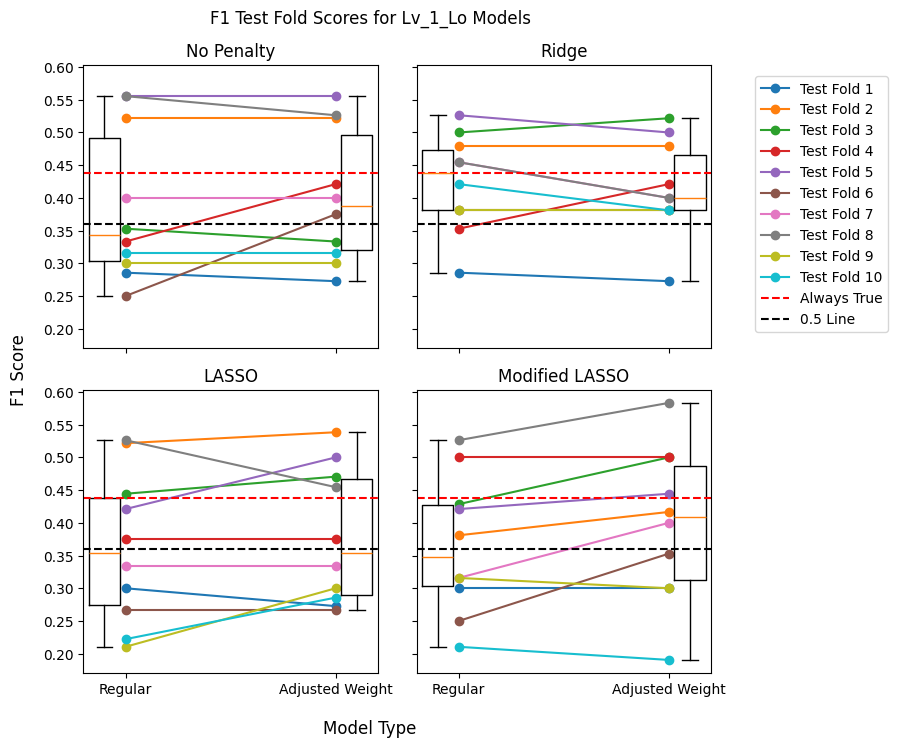

In [5]:
graph_folds(reg_f1_scores, adj_wt_f1_scores, outcomes_df, "Lv_1_Lo", "F1", ["Regular", "Adjusted Weight"])

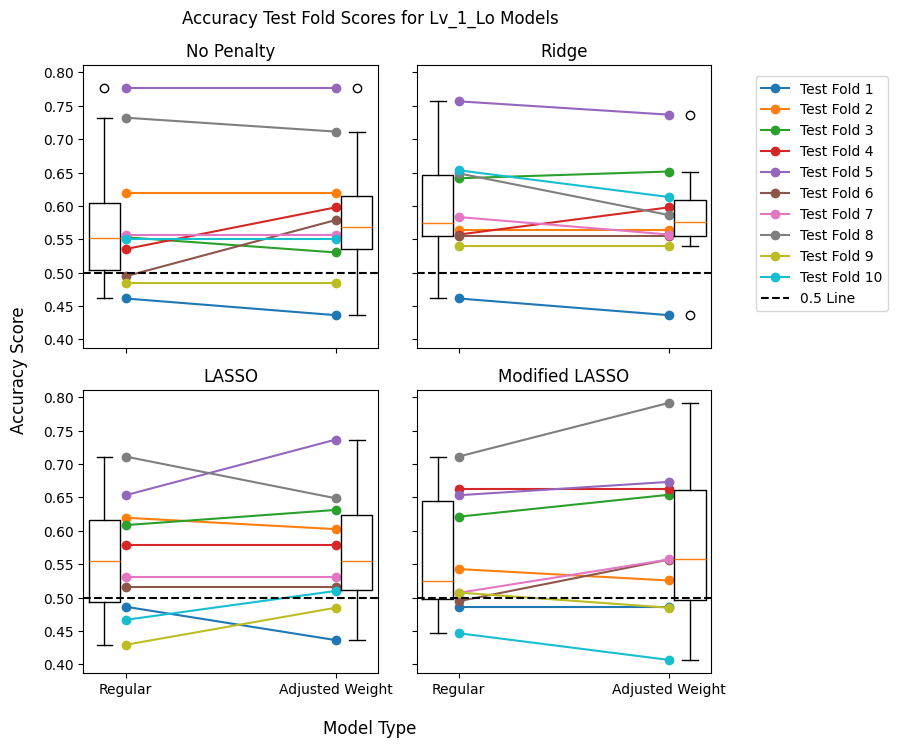

In [6]:
graph_folds(reg_accuracy_scores, adj_wt_accuracy_scores, outcomes_df, "Lv_1_Lo", "Accuracy", ["Regular", "Adjusted Weight"])

## t-tests

### F1

In [14]:
# Paired t-test
print(f'{"Penalty" : <30}{"t" : <7}{"p" : <7}')
for penalty in ["No Penalty", "Ridge", "LASSO", "Modified LASSO"]:
    t_stat, p_val = stats.ttest_rel(reg_f1_scores["Lv_1_Lo"][penalty], adj_wt_f1_scores["Lv_1_Lo"][penalty])
    print(f'{penalty : <30}{t_stat : <7.3f}{p_val : >5.3f}')

Penalty                       t      p      
No Penalty                    -0.955 0.364
Ridge                         0.835  0.425
LASSO                         -1.123 0.290
Modified LASSO                -2.463 0.036


### Balanced Accuracy

In [15]:
# Paired t-test
print(f'{"Penalty" : <30}{"t" : <7}{"p" : <7}')
for penalty in ["No Penalty", "Ridge", "LASSO", "Modified LASSO"]:
    t_stat, p_val = stats.ttest_rel(reg_accuracy_scores["Lv_1_Lo"][penalty], adj_wt_accuracy_scores["Lv_1_Lo"][penalty])
    print(f'{penalty : <30}{t_stat : <7.3f}{p_val : >5.3f}')

Penalty                       t      p      
No Penalty                    -0.678 0.515
Ridge                         1.348  0.211
LASSO                         -0.525 0.612
Modified LASSO                -1.330 0.216


# Regular vs. SMOTE

In [9]:
SMOTE_f1_scores["Lv_1_Lo"]["Modified LASSO"] = SMOTE_f1_scores["Lv_1_Lo"]["Modified LASSO (No Penalty)"]
SMOTE_accuracy_scores["Lv_1_Lo"]["Modified LASSO"] = SMOTE_accuracy_scores["Lv_1_Lo"]["Modified LASSO (No Penalty)"]

## Graphs

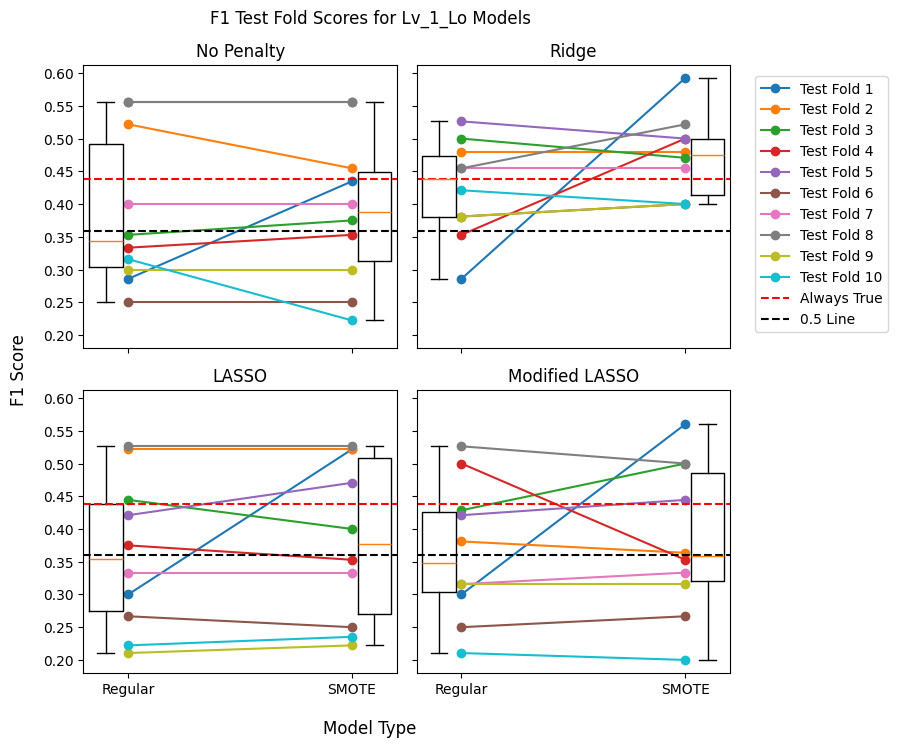

In [10]:
graph_folds(reg_f1_scores, SMOTE_f1_scores, outcomes_df, "Lv_1_Lo", "F1", ["Regular", "SMOTE"])

## t-tests

### F1

In [12]:
# Paired t-test
print(f'{"Penalty" : <30}{"t" : <7}{"p" : <7}')
for penalty in ["No Penalty", "Ridge", "LASSO", "Modified LASSO"]:
    t_stat, p_val = stats.ttest_rel(reg_f1_scores["Lv_1_Lo"][penalty], SMOTE_f1_scores["Lv_1_Lo"][penalty])
    print(f'{penalty : <30}{t_stat : <7.3f}{p_val : >5.3f}')

Penalty                       t      p      
No Penalty                    -0.149 0.885
Ridge                         -1.449 0.181
LASSO                         -0.902 0.391
Modified LASSO                -0.584 0.573


# Adjusted Weight vs SMOTE

## Graphs

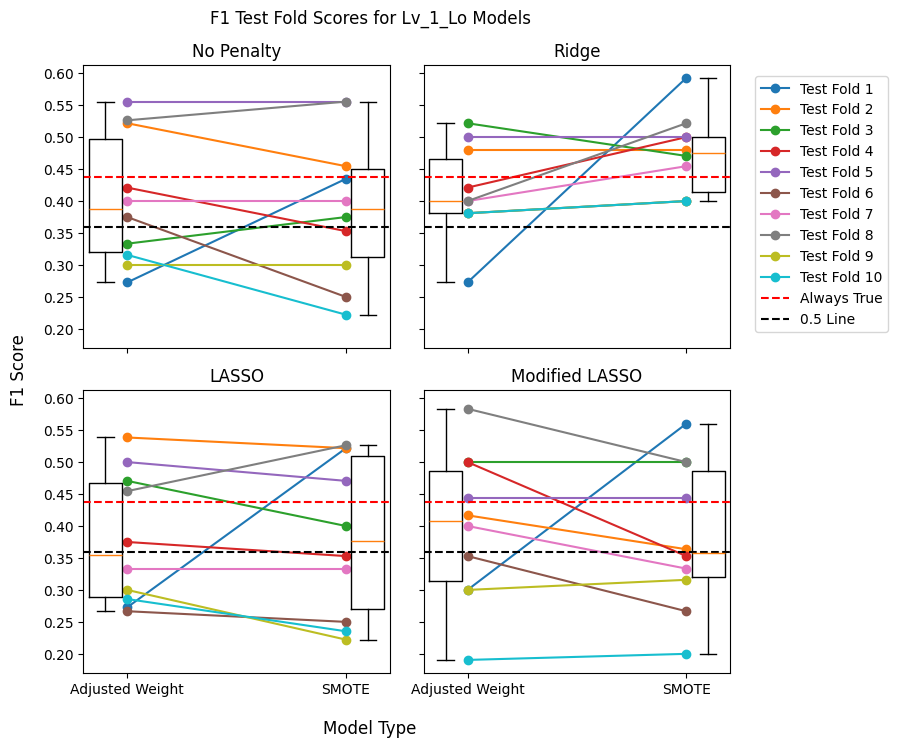

In [11]:
graph_folds(adj_wt_f1_scores, SMOTE_f1_scores, outcomes_df, "Lv_1_Lo", "F1", ["Adjusted Weight", "SMOTE"])

## t-tests

### F1

In [14]:
# Paired t-test
print(f'{"Penalty" : <30}{"t" : <7}{"p" : <7}')
for penalty in ["No Penalty", "Ridge", "LASSO", "Modified LASSO"]:
    t_stat, p_val = stats.ttest_rel(adj_wt_f1_scores["Lv_1_Lo"][penalty], SMOTE_f1_scores["Lv_1_Lo"][penalty])
    print(f'{penalty : <30}{t_stat : <7.3f}{p_val : >5.3f}')

Penalty                       t      p      
No Penalty                    0.465  0.653
Ridge                         -1.777 0.109
LASSO                         -0.123 0.905
Modified LASSO                0.434  0.674


# SMOTE Raw vs Adjusted SA

In [18]:
def graph_folds(model_1_test_scores, model_2_test_scores, outcome_var, metric, model_names):
    fig, axes = plt.subplots(2, 4, sharex = True, sharey = True)
    fig.set_figheight(7.5)
    fig.set_figwidth(15)

    for graph_no, (ax, penalty) in enumerate(
        [
            (axes[0, 0], "Ridge"), 
            (axes[0, 1], "Modified Ridge (No Penalty)"), 
            (axes[0, 2], "Modified Ridge (L2)"), 
            (axes[0, 3], "No Penalty"), 
            (axes[1, 0], "LASSO"), 
            (axes[1, 1], "Modified LASSO (No Penalty)"), 
            (axes[1, 2], "Modified LASSO (L2)")
        ]):
        
        # Plot Actual vs Shuffled
        for i, (actual_score, shuffled_score) in enumerate(zip(model_1_test_scores[outcome_var][penalty], model_2_test_scores[outcome_var][penalty])):
            ax.plot([0, 1], [actual_score, shuffled_score], marker = "o", label = f"Test Fold {i + 1}")

        # Actual Data Boxplot
        ax.boxplot(model_1_test_scores[outcome_var][penalty], vert = True, positions = [-0.1])

        # Shuffled Data Boxplot
        ax.boxplot(model_2_test_scores[outcome_var][penalty], vert = True, positions = [1.1])

        # Baselines
        ax.axhline(y = 0.5, color = "black", label = "0.5 Line", linestyle = "--")

        # Visual Adjustments
        ax.set_xticks([0, 1], model_names)
        ax.set_xlim([-0.2, 1.2])

        # Labeling Per Graph
        ax.set_title(penalty)
    
    # Labeling
    fig.supxlabel("Model Type")
    fig.supylabel(f"{metric} Score")
    fig.suptitle(f"{metric} Test Fold Scores for {outcome_var} Models")

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc = "upper right", bbox_to_anchor = [1.1, 0.9])
    fig.tight_layout()

## F1

### Graphs

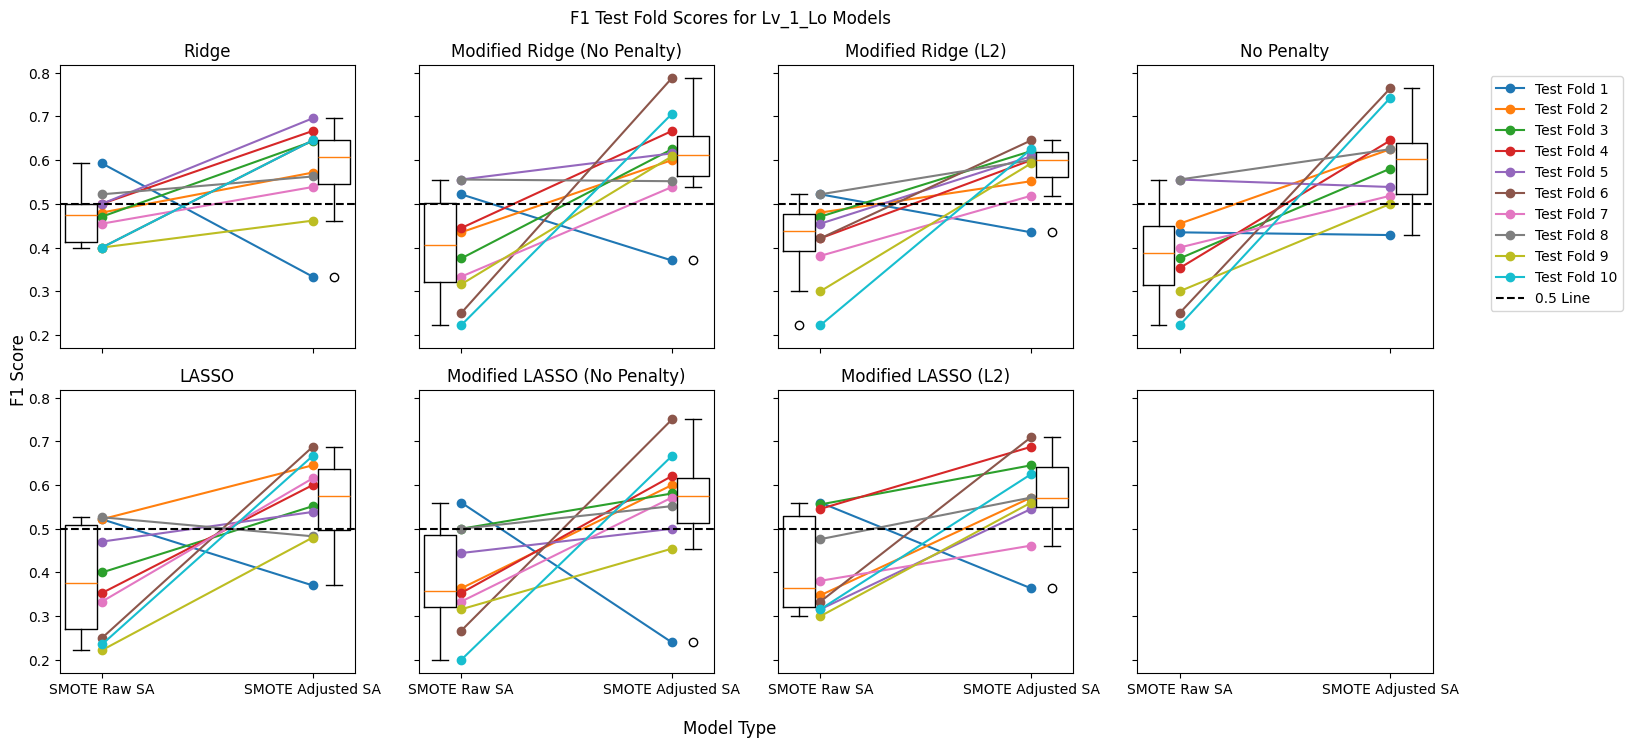

In [12]:
graph_folds(SMOTE_f1_scores, SMOTE_adjSA_f1_scores, "Lv_1_Lo", "F1", ["SMOTE Raw SA", "SMOTE Adjusted SA"])

### t-tests

In [13]:
print("Paired (Raw SA vs. Adjusted SA)")
print(f'{"Penalty" : <30}{"t" : <7}{"p" : <7}')
for penalty in ["No Penalty", "Ridge", "Modified Ridge (No Penalty)", "Modified Ridge (L2)", "LASSO", "Modified LASSO (No Penalty)", "Modified LASSO (L2)"]:
    t_stat, p_val = stats.ttest_rel(SMOTE_f1_scores["Lv_1_Lo"][penalty], SMOTE_adjSA_f1_scores["Lv_1_Lo"][penalty])
    print(f'{penalty : <30}{t_stat : <7.3f}{p_val : >5.3f}')

Paired (Raw SA vs. Adjusted SA)
Penalty                       t      p      
No Penalty                    -3.447 0.007
Ridge                         -2.240 0.052
Modified Ridge (No Penalty)   -3.125 0.012
Modified Ridge (L2)           -3.838 0.004
LASSO                         -2.993 0.015
Modified LASSO (No Penalty)   -2.324 0.045
Modified LASSO (L2)           -3.180 0.011


## Accuracy

### Graphs

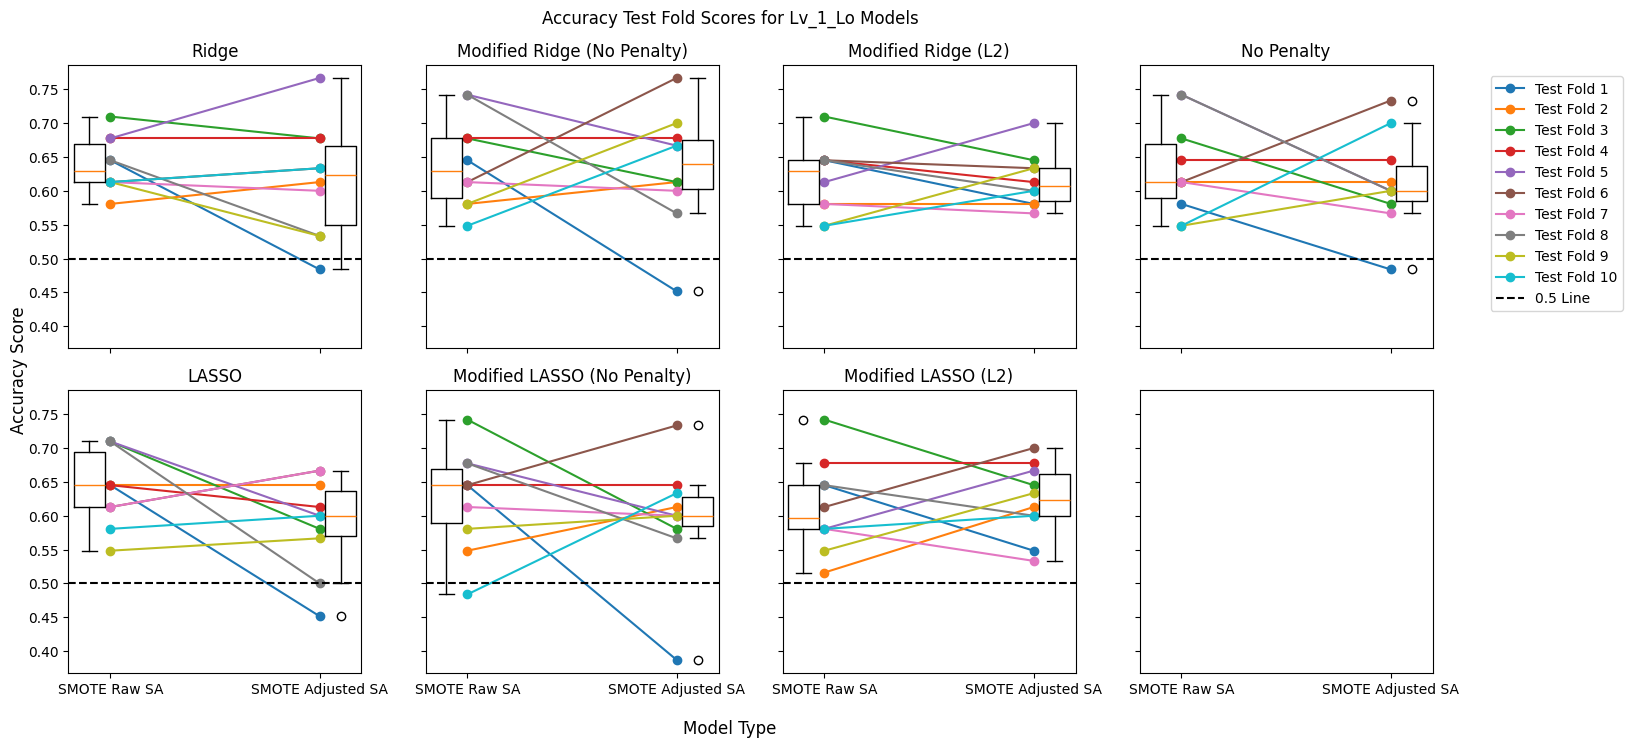

In [14]:
graph_folds(SMOTE_accuracy_scores, SMOTE_adjSA_accuracy_scores, "Lv_1_Lo", "Accuracy", ["SMOTE Raw SA", "SMOTE Adjusted SA"])

### t-tests

In [19]:
print("Paired (Raw SA vs. Adjusted SA)")
print(f'{"Penalty" : <30}{"t" : <7}{"p" : <7}')
for penalty in ["No Penalty", "Ridge", "Modified Ridge (No Penalty)", "Modified Ridge (L2)", "LASSO", "Modified LASSO (No Penalty)", "Modified LASSO (L2)"]:
    t_stat, p_val = stats.ttest_rel(SMOTE_accuracy_scores["Lv_1_Lo"][penalty], SMOTE_adjSA_accuracy_scores["Lv_1_Lo"][penalty])
    print(f'{penalty : <30}{t_stat : <7.3f}{p_val : >5.3f}')

Paired (Raw SA vs. Adjusted SA)
Penalty                       t      p      
No Penalty                    0.608  0.558
Ridge                         0.996  0.345
Modified Ridge (No Penalty)   0.257  0.803
Modified Ridge (L2)           0.048  0.963
LASSO                         1.676  0.128
Modified LASSO (No Penalty)   0.767  0.463
Modified LASSO (L2)           -0.359 0.728
